# Étude du client 39

In [1]:
#import des librairies
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from joblib import dump

import sys
sys.path.append("../../scripts/")

# librairies perso
from import_data import import_data, import_data_complete
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure
from metrics import export_mesure, permutation_feature_importance

In [2]:
np.random.seed(42)

In [3]:
data = import_data_complete(path = "../../")

In [4]:
# on sélectionne le bon client : 
client = 39
data = data.groupby("id_client").get_group(client)
data = data.reset_index()
data = data.drop(["index", "id_client", "prediction"], axis = 1 )

In [5]:
# création des dossiers utiles
folder1 = f"../../output/client_{client}"
folder2 = f"../../output/client_{client}/modèles"
folder3 = f"../../output/client_{client}/plot"

# Vérifier si les dossier n'existe pas déjà
if not os.path.exists(folder1):
    os.makedirs(folder1)
if not os.path.exists(folder2):
    os.makedirs(folder2)
if not os.path.exists(folder3):
    os.makedirs(folder3)

In [6]:
# création d'un dataFrame où on stocke les résulats
results = pd.DataFrame(columns = ["MSE", "MAE", "R2", "crossVal"])
def concat_results(name, result): 
    df = pd.DataFrame(result, columns = [name], index = results.columns).T
    return pd.concat([results, df])

# Traitement des données

## On enlève les NaN

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   horodate                760 non-null    datetime64[ns]
 1   real_consumption        760 non-null    float64       
 2   forecasted_consumption  760 non-null    float64       
 3   CAC                     760 non-null    float64       
 4   AEX                     760 non-null    float64       
 5   BFX                     760 non-null    float64       
 6   STOXX                   760 non-null    float64       
 7   Airliquide              760 non-null    float64       
 8   gasNat                  760 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 53.6 KB


In [8]:
data.dropna(axis=1, inplace=True)

## On enlève les zéros en trop 

In [9]:
non_zero = np.max(np.where(data["real_consumption"] != 0))
data = data.iloc[:non_zero, :]
data.to_csv(f"../../output/client_{client}/client_{client}.csv")
data

,horodate,real_consumption,forecasted_consumption,CAC,AEX,BFX,STOXX,Airliquide,gasNat
0,2021-01-01,5412.00,5525.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
1,2021-01-02,5084.00,5525.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
2,2021-01-03,5073.00,5525.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
3,2021-01-04,5070.00,5525.0,5614.040039,632.020020,3671.080078,3565.679932,123.590912,2.626
4,2021-01-05,5053.23,5525.0,5561.600098,629.940002,3645.760010,3554.239990,123.136360,2.599
...,...,...,...,...,...,...,...,...,...
741,2023-01-13,2554.54,5300.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
742,2023-01-14,2563.17,5300.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
743,2023-01-15,2562.80,5300.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
744,2023-01-16,2563.38,5300.0,7036.479980,748.940002,3944.040039,4155.740234,143.339996,3.677


# Visualisation des données

## Consommation prédite vs consommation réelle

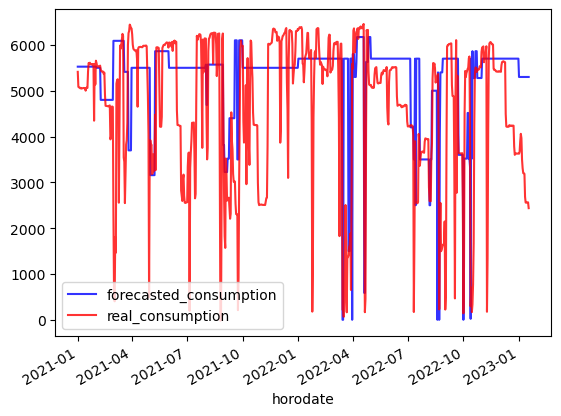

In [10]:
data.plot(x = "horodate", y = ["forecasted_consumption","real_consumption"], color = ["blue", "red"], alpha = 0.8)
plt.savefig(f"../../output/client_{client}/forecasted_vs_real.jpg");

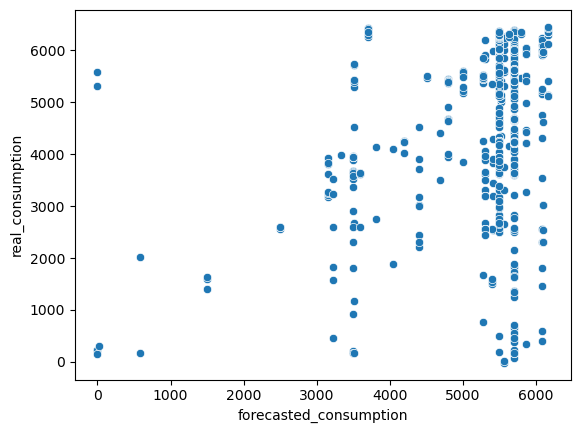

In [11]:
sns.scatterplot(x = "forecasted_consumption", y = "real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_forecasted_vs_real.jpg");

## Etude des corrélations

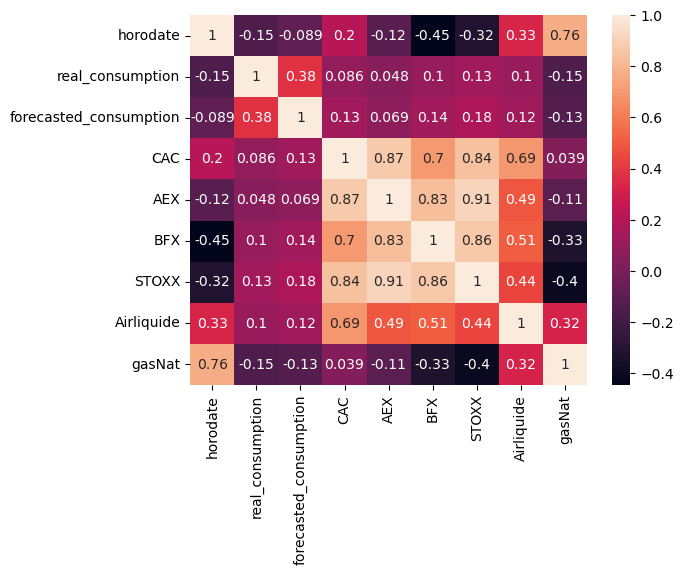

In [12]:
sns.heatmap(data.corr(), annot=True)
plt.savefig(f"../../output/client_{client}/corr.png");

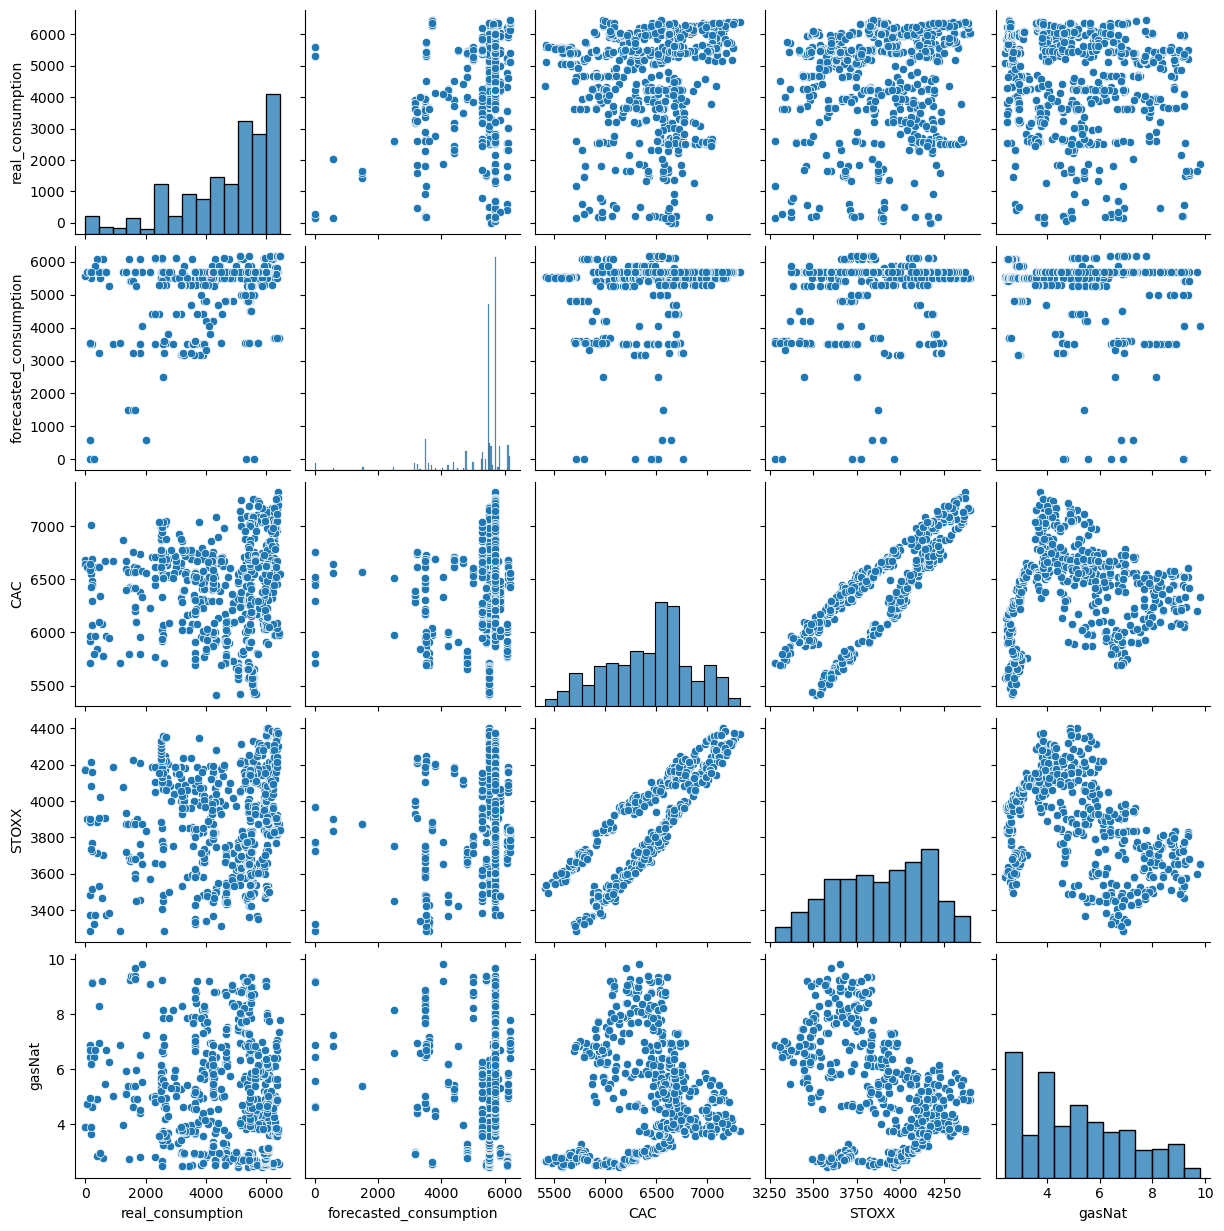

In [13]:
sns.pairplot(data[["real_consumption", "forecasted_consumption", "CAC", "STOXX", "gasNat"]])
plt.savefig(f"../../output/client_{client}/scatter_corr.png");

### CAC

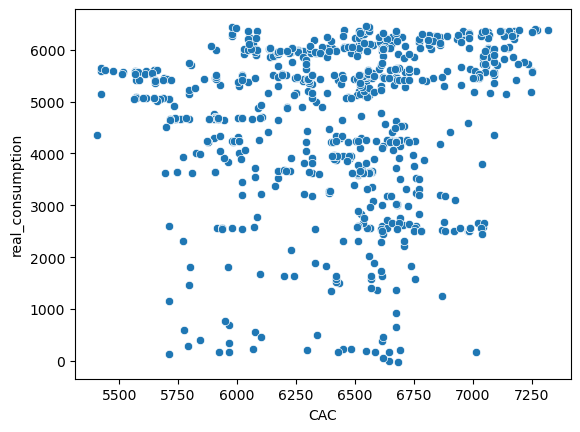

In [14]:
sns.scatterplot(x = "CAC", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_cac_real"); 

### BFX

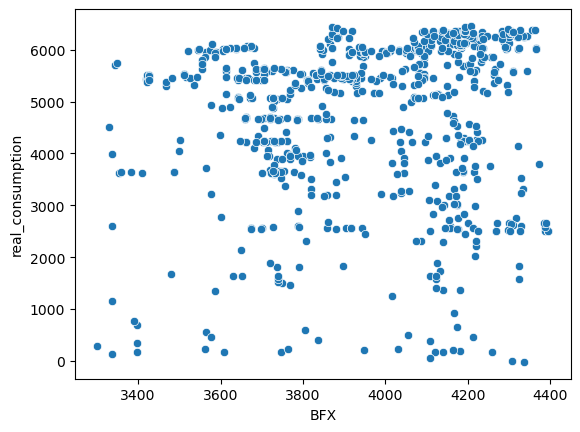

In [15]:
sns.scatterplot(x = "BFX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_bfx_real"); 

### AEX

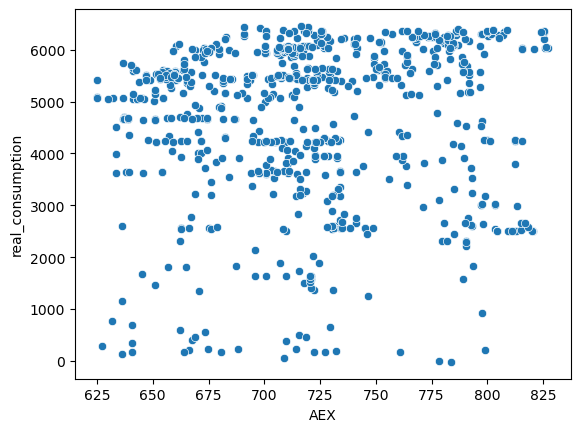

In [16]:
sns.scatterplot(x = "AEX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_aex_real"); 

### STOXX

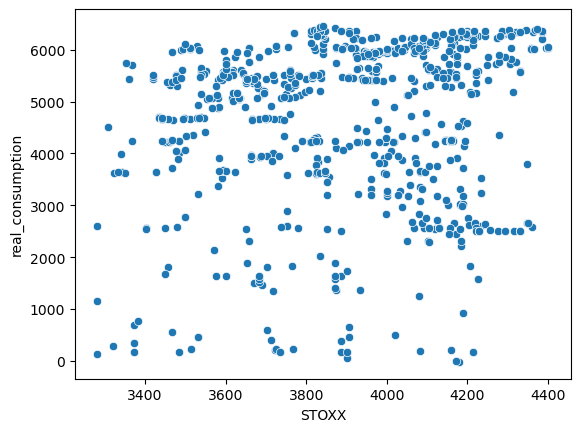

In [17]:
sns.scatterplot(x = "STOXX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_stoxx_real"); 

### Gas naturel

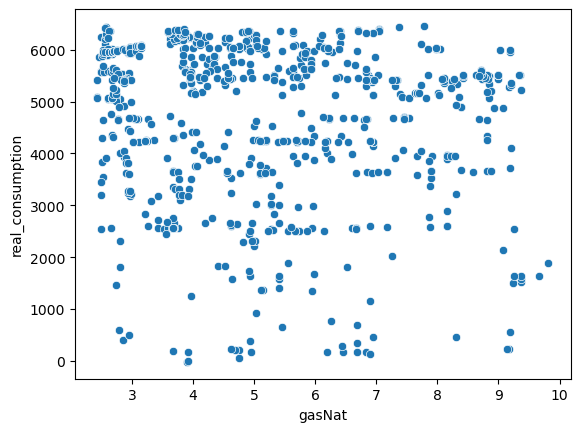

In [18]:
sns.scatterplot(x = "gasNat", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_gasNat_real"); 

# Application des modèles

## Modèle 1 : régression linéaire

### Avec une seule variable : forecasted_consumption

In [19]:
# découpage des sets de données
X = data[["forecasted_consumption"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [21]:
# création du modèle
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

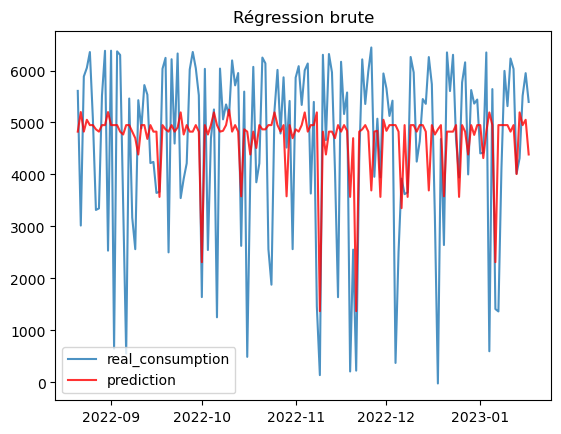

In [22]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Régression brute")
plt.legend()
plt.savefig(f"../../output/client_{client}/simple_linear_regression.png");

In [23]:
# enregistrement plot
data[["horodate", "real_consumption", "forecasted_consumption"]].rename({"horodate": "time", "real_consumption": "y1", "forecasted_consumption": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot0.csv")
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot1.csv")

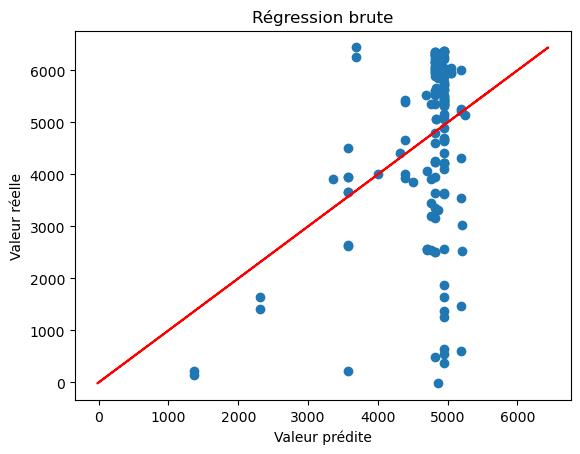

In [24]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Régression brute")
plt.savefig(f"../../output/client_{client}/simple_linear_regression_scatter.png");

#### Erreur de prédiction du client

In [25]:
# erreur entre la consommation réelle et celle prédite par le client
error = [mean_squared_error(y_test, X_test["forecasted_consumption"]), mean_absolute_error(y_test, X_test["forecasted_consumption"]), r2_score(y_test, X_test["forecasted_consumption"])]
error.append(np.NaN)
error

[3091507.8368886663, 1164.7974, -0.07594770806320028, nan]

In [26]:
results = concat_results("erreur_prediction_client",error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3.091508e+06,1164.7974,-0.075948,NaN


#### Erreur du modèle 

In [27]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]

In [28]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
print(f"Validation croisée (r2) : {scores}")

Validation croisée (r2) : [ 0.08451798 -0.02311064  0.14713851  0.24990952  0.19782751]


In [29]:
#results = concat_results("erreur_regression_simple_train", error_train)
results = concat_results("erreur_regression_simple_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_regression_simple_test,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"


In [30]:
# enregistrement du modèle
dump(model, f'../../output/client_{client}/modèles/simple_linear_regression.joblib');

### Avec toutes les données boursières

In [31]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [33]:
# création du modèle
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

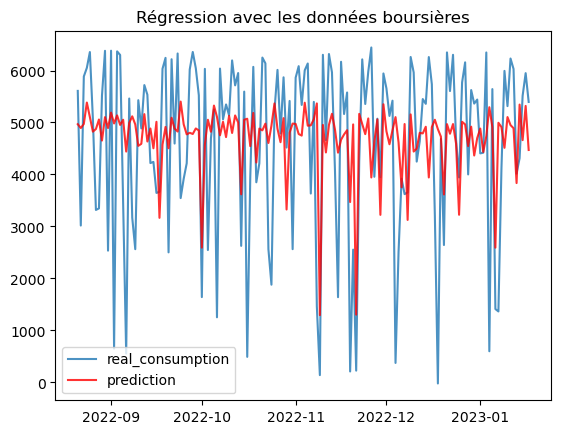

In [34]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Régression avec les données boursières")
plt.legend()
plt.savefig(f"../../output/client_{client}/complet_linear_regression.png");

In [35]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot2.csv")

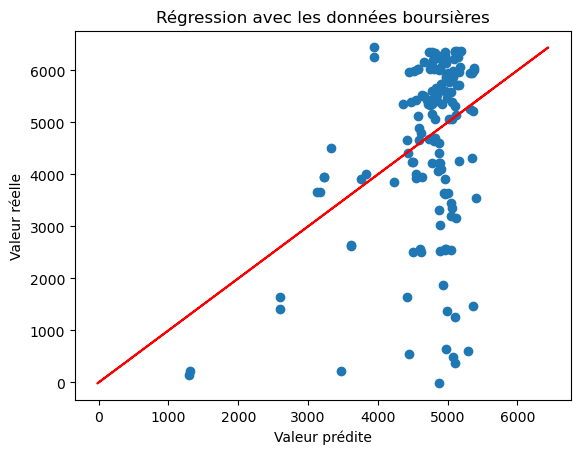

In [36]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Régression avec les données boursières")
plt.savefig(f"../../output/client_{client}/complete_linear_regression_scatter.png");

#### Erreur du modèle 

In [37]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[2479769.2497791206, 1211.7041675395105, 0.136957697797506]

In [38]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.09368151, 0.01173128, 0.13352909, 0.26909966, 0.20080582])

In [39]:
#results = concat_results("erreur_regression_complete_train", error_train)
results = concat_results("erreur_regression_complete_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_regression_simple_test,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_regression_complete_test,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"


In [40]:
# enregistrement du modèle
dump(model, f'../../output/client_{client}/modèles/complet_linear_regression.joblib');

## Modèle 2 : Random Forest

In [41]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [43]:
# création du modèle
model = RandomForestRegressor(n_estimators=200,random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

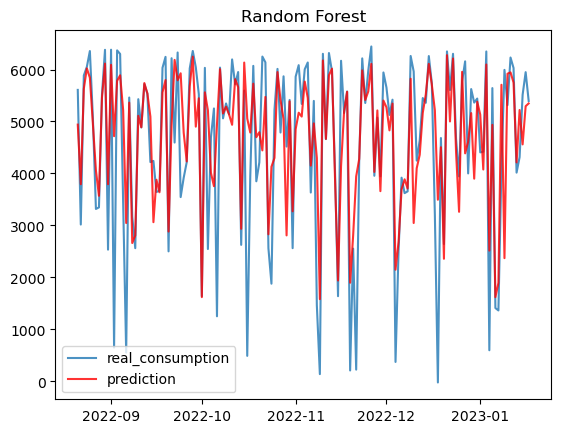

In [44]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Random Forest")
plt.legend()
plt.savefig(f"../../output/client_{client}/random_forest.png");

In [45]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot3.csv")

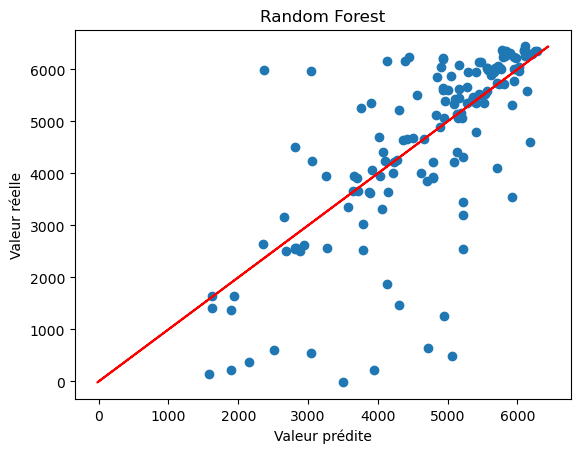

In [46]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Random Forest")
plt.savefig(f"../../output/client_{client}/random_forest_scatter.png");

#### Erreur du modèle

In [47]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[1350703.036003917, 729.0594807419308, 0.5299103503729019]

In [48]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.52022778, 0.5077651 , 0.45445726, 0.43682947, 0.43311946])

In [49]:
#results = concat_results("erreur_random_forest_train", error_train)
results = concat_results("erreur_random_forest_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_regression_simple_test,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_regression_complete_test,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"
erreur_random_forest_test,1350703.036004,729.059481,0.52991,"[0.52, 0.508, 0.454, 0.437, 0.433]"


In [50]:
# enregistrement du modèle 
dump(model, f'../../output/client_{client}/modèles/random_forest.joblib');

## Modèle 3 : Gradient Boosting

In [51]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [53]:
# création du modèle
model = GradientBoostingRegressor(n_estimators=200,random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

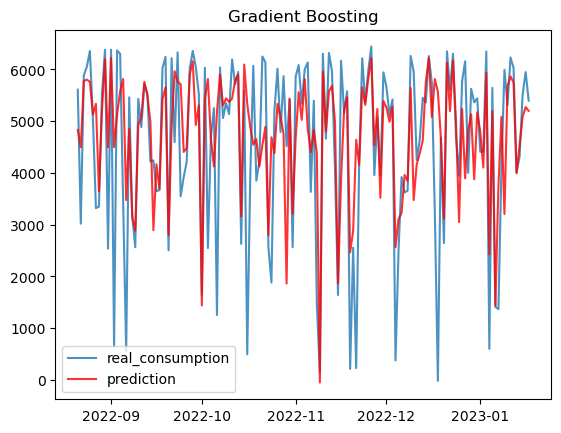

In [54]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Gradient Boosting")
plt.legend()
plt.savefig(f"../../output/client_{client}/gradient_boosting.png");

In [55]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot4.csv")

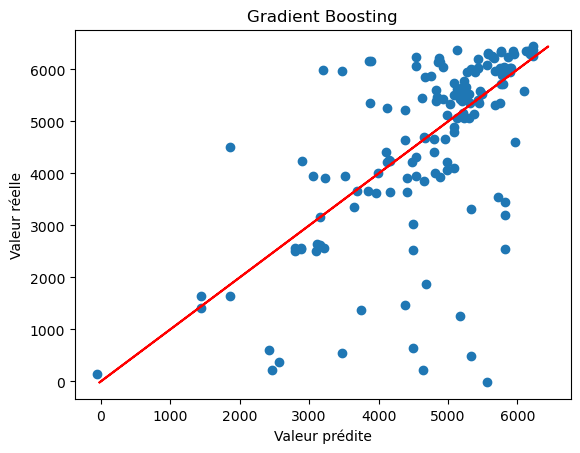

In [56]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Gradient Boosting")
plt.savefig(f"../../output/client_{client}/gradient_boosting_scatter.png");

#### Erreurs du modèle

In [57]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[1751975.47656436, 845.5201240756408, 0.3902541743224306]

In [58]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.40264165, 0.44594116, 0.32814791, 0.3372748 , 0.35219286])

In [59]:
#results = concat_results("erreur_gradient_boosting_train", error_train)
results = concat_results("erreur_gradient_boosting_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_regression_simple_test,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_regression_complete_test,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"
erreur_random_forest_test,1350703.036004,729.059481,0.52991,"[0.52, 0.508, 0.454, 0.437, 0.433]"
erreur_gradient_boosting_test,1751975.476564,845.520124,0.390254,"[0.403, 0.446, 0.328, 0.337, 0.352]"


In [60]:
# enristrement du modèle
dump(model, f"../../output/client_{client}/modèles/gradient_boosting.joblib");

## Modèle 4 : Support vector machine

In [61]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [63]:
"""
# on règle la machine à vecteur de support 
param_grid = {
    'C': [100, 150, 200, 250],
    'kernel': ["poly"],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [1.0, 2.0, 3.0]
}

# Créer le modèle Gradient Boosting
SVM = SVR()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Effectuer la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train_norm, y_train)
grid_search.best_estimator_
"""

'\n# on règle la machine à vecteur de support \nparam_grid = {\n    \'C\': [100, 150, 200, 250],\n    \'kernel\': ["poly"],\n    \'gamma\': [\'scale\', \'auto\'],\n    \'degree\': [2, 3, 4],\n    \'coef0\': [1.0, 2.0, 3.0]\n}\n\n# Créer le modèle Gradient Boosting\nSVM = SVR()\n\n# Créer l\'objet GridSearchCV\ngrid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\n# Effectuer la recherche sur grille sur les données d\'entraînement\ngrid_search.fit(X_train_norm, y_train)\ngrid_search.best_estimator_\n'

In [64]:
model = SVR(C=250, coef0=3.0, degree=4, kernel='poly')

In [65]:
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

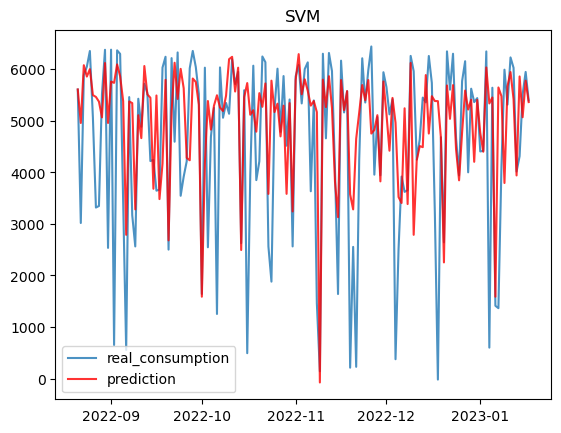

In [66]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("SVM")
plt.legend()
plt.savefig(f"../../output/client_{client}/SVM.png");

In [67]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot5.csv")

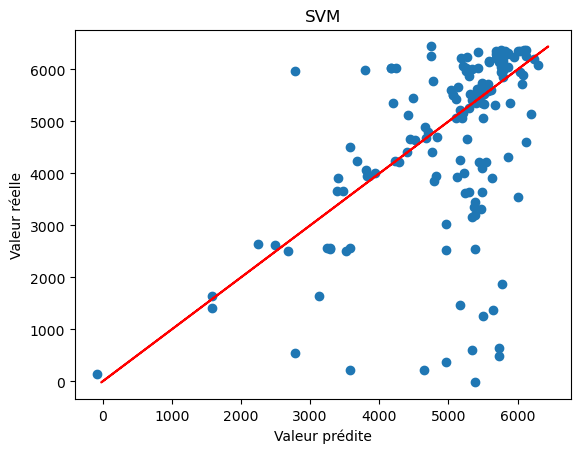

In [68]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("SVM")
plt.savefig(f"../../output/client_{client}/SVM_scatter.png");

#### Erreurs sur le modèle

In [69]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[2370668.5864044474, 961.723844727758, 0.17492836289026992]

In [70]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.14424301, 0.11153155, 0.24484082, 0.16888084, 0.4122931 ])

In [71]:
#results = concat_results("erreur_SVM_train", error_train)
results = concat_results("erreur_SVM_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_regression_simple_test,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_regression_complete_test,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"
erreur_random_forest_test,1350703.036004,729.059481,0.52991,"[0.52, 0.508, 0.454, 0.437, 0.433]"
erreur_gradient_boosting_test,1751975.476564,845.520124,0.390254,"[0.403, 0.446, 0.328, 0.337, 0.352]"
erreur_SVM_test,2370668.586404,961.723845,0.174928,"[0.144, 0.112, 0.245, 0.169, 0.412]"


In [72]:
# enregistrement du modèle
dump(model, f"../../output/client_{client}/modèles/SVM.joblib");

## Bruit sur les données boursières

In [73]:
data_perturbation = data.copy()
data_perturbation.describe()

,horodate,real_consumption,forecasted_consumption,CAC,AEX,BFX,STOXX,Airliquide,gasNat
count,746,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,2022-01-09 06:27:59.356568320,4667.163056,5284.500000,6434.875909,719.256179,3951.304588,3891.645829,132.744779,5.103050
min,2021-01-01 00:00:00,-20.000000,0.000000,5407.740234,625.190002,3301.310059,3282.000000,114.318184,2.433000
25%,2021-07-07 06:00:00,3810.000000,5500.000000,6143.532593,679.799988,3739.804993,3669.040039,127.372725,3.617000
50%,2022-01-09 12:00:00,5258.420000,5525.000000,6514.010010,715.284973,3957.719971,3917.844971,133.409088,4.870000
75%,2022-07-14 18:00:00,5949.750000,5700.000000,6688.822388,754.020020,4172.830078,4118.682495,137.909088,6.525750
max,2023-01-17 00:00:00,6457.000000,6172.000000,7320.479980,827.380005,4395.319824,4400.729980,153.220001,9.817000
std,NaN,1551.397253,927.991151,415.626964,49.258048,253.074740,267.250673,8.040987,1.936111


In [74]:
n = len(data_perturbation)

# pour le CAC
data_perturbation["CAC"] += np.random.normal(0, 100, n)

# pour l'AEX 
data_perturbation["AEX"] += np.random.normal(0,10, n)

# pour le BFX 
data_perturbation["BFX"] += np.random.normal(0, 70, n)

# pour le STOXX 
data_perturbation["STOXX"] += np.random.normal(0,70, n)

# pour le gasNat 
data_perturbation["gasNat"] += np.random.normal(0,0.2, n)

In [75]:
# découpage des sets de données
X = data_perturbation[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data_perturbation["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [77]:
# création du modele 
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

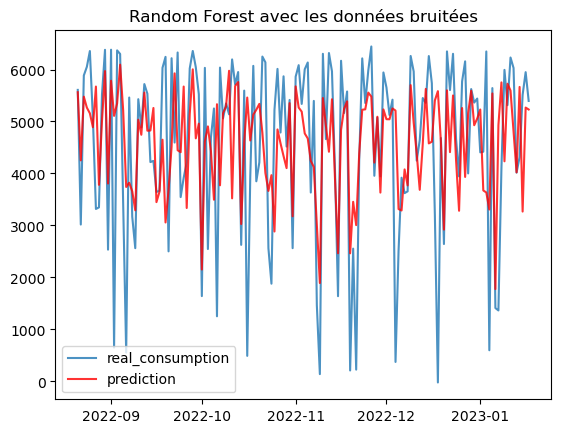

In [78]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Random Forest avec les données bruitées")
plt.legend()
plt.savefig(f"../../output/client_{client}/random_forest_bruit.png");

In [79]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot6.csv")

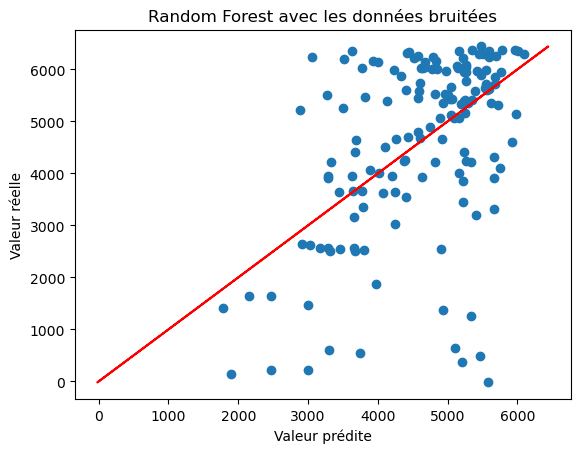

In [80]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Random Forest avec les données bruitées")
plt.savefig(f"../../output/client_{client}/random_forest_scatter_bruit.png");

#### Erreur du modèle 

In [81]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[2214195.4690191746, 1072.0231833333337, 0.2293862199965372]

In [82]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.30830135, 0.25870194, 0.32374218, 0.34600384, 0.33229075])

In [83]:
#results = concat_results("erreur_random_forest_bruit_train", error_train)
results = concat_results("erreur_random_forest_bruit_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507.836889,1164.7974,-0.075948,NaN
erreur_regression_simple_test,2483729.982565,1209.079311,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_regression_complete_test,2479769.249779,1211.704168,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"
erreur_random_forest_test,1350703.036004,729.059481,0.52991,"[0.52, 0.508, 0.454, 0.437, 0.433]"
erreur_gradient_boosting_test,1751975.476564,845.520124,0.390254,"[0.403, 0.446, 0.328, 0.337, 0.352]"
erreur_SVM_test,2370668.586404,961.723845,0.174928,"[0.144, 0.112, 0.245, 0.169, 0.412]"
erreur_random_forest_bruit_test,2214195.469019,1072.023183,0.229386,"[0.308, 0.259, 0.324, 0.346, 0.332]"


In [84]:
# enregistrement du modèle
dump(model, f"../../output/client_{client}/modèles/random_forest_bruit.joblib");

## Gradient Boosting avec xgboost

In [85]:
import xgboost as xgb

In [86]:
# découpage des sets de données
X = data_perturbation[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data_perturbation["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [88]:
params = {
    'objective': 'reg:squarederror',  # Pour un problème de régression
    'eval_metric': 'rmse',  # Métrique d'évaluation : erreur quadratique moyenne
    'eta': 0.1,  # Taux d'apprentissage (learning rate)
    'max_depth': 5,  # Profondeur maximale de l'arbre
    'min_child_weight': 1,  # Poids minimum d'un exemple pour créer un nouveau nœud
    'gamma': 0,  # Paramètre de régularisation pour la réduction de l'erreur
    'subsample': 0.8,  # Taux d'échantillonnage des exemples pour la construction d'arbres
    'colsample_bytree': 0.8,  # Taux d'échantillonnage des caractéristiques pour la construction d'arbres
    'seed': 42  # Graine aléatoire pour la reproductibilité
}

In [89]:
model = xgb.XGBRegressor(**params)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

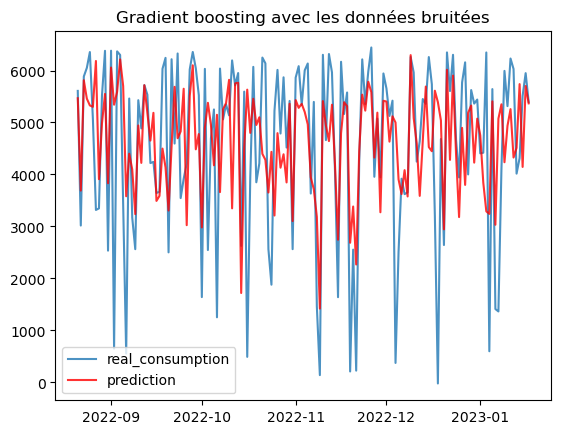

In [90]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Gradient boosting avec les données bruitées")
plt.legend()
plt.savefig(f"../../output/client_{client}/xgboost_bruit.png");

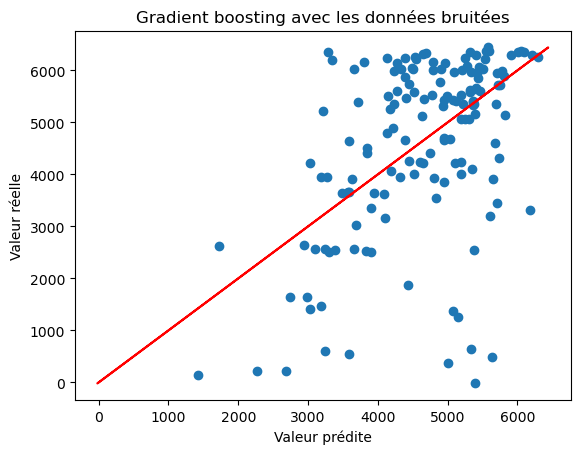

In [91]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Gradient boosting avec les données bruitées")
plt.savefig(f"../../output/client_{client}/xgboost_scatter_bruit.png");

#### Erreur du modèle 

In [92]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[2201588.013001508, 1074.5586774739584, 0.23377403465605562]

In [93]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.23242562, 0.25623153, 0.29556336, 0.21438147, 0.22692018])

In [94]:
#results = concat_results("xgb_bruit_train", error_train)
results = concat_results("xbg_bruit_test", error_test)
results[["MSE", "MAE"]] = results[["MSE", "MAE"]].astype(int)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,3091507,1164,-0.075948,NaN
erreur_regression_simple_test,2483729,1209,0.135579,"[0.085, -0.023, 0.147, 0.25, 0.198]"
erreur_regression_complete_test,2479769,1211,0.136958,"[0.094, 0.012, 0.134, 0.269, 0.201]"
erreur_random_forest_test,1350703,729,0.52991,"[0.52, 0.508, 0.454, 0.437, 0.433]"
erreur_gradient_boosting_test,1751975,845,0.390254,"[0.403, 0.446, 0.328, 0.337, 0.352]"
erreur_SVM_test,2370668,961,0.174928,"[0.144, 0.112, 0.245, 0.169, 0.412]"
erreur_random_forest_bruit_test,2214195,1072,0.229386,"[0.308, 0.259, 0.324, 0.346, 0.332]"
xbg_bruit_test,2201588,1074,0.233774,"[0.232, 0.256, 0.296, 0.214, 0.227]"


In [95]:
# enregistrement du modèle
dump(model, f"../../output/client_{client}/modèles/xgboost_bruit.joblib");

In [96]:
# enregistrement des résultats 
results.to_csv(f"../../output/client_{client}/results.csv")